# Traffic Light Detection

This notebook is used to test and explore different trained traffic light detection models

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Load label map
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'bstld_label_map.pbtxt')

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [3]:
# Load test images
PATH_TO_TEST_IMAGES_DIR = 'assets/simulator'
test_images = os.listdir(PATH_TO_TEST_IMAGES_DIR)

## Load simulator trained traffic models

In [37]:
# Simulator trained models
SSD_MOBILENET_V2_COCO_FILE = 'models/ssd_mobilenet_v2_coco_simulator/frozen_inference_graph.pb'
SSD_INCEPTION_V2_COCO_FILE = 'models/ssd_inception_v2_coco_simulator/frozen_inference_graph.pb'
FASTER_RCNN_INCEPTION_V2_COCO_FILE = 'models/faster_rcnn_inception_v2_coco_simulator/frozen_inference_graph.pb'
FASTER_RCNN_RESNET101_COCO_FILE = 'models/faster_rcnn_resnet101_coco_simulator/frozen_inference_graph.pb'


Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [38]:
# Colors (one for each class)
cmap = ImageColor.colormap
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

## Choose a graph to load

In [39]:
## Choose a graph to load
# detection_graph = load_graph(SSD_MOBILENET_V2_COCO_FILE)
# detection_graph = load_graph(SSD_INCEPTION_V2_COCO_FILE)
# detection_graph = load_graph(FASTER_RCNN_INCEPTION_V2_COCO_FILE)
detection_graph = load_graph(FASTER_RCNN_RESNET101_COCO_FILE)


# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

Run detection and classification on sample images.

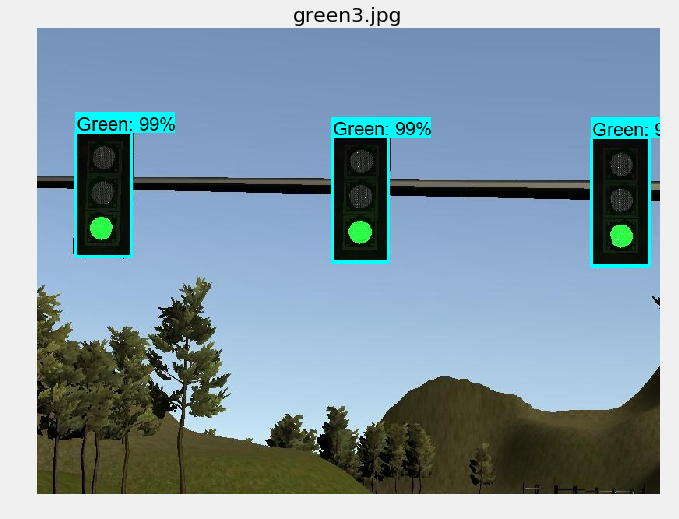

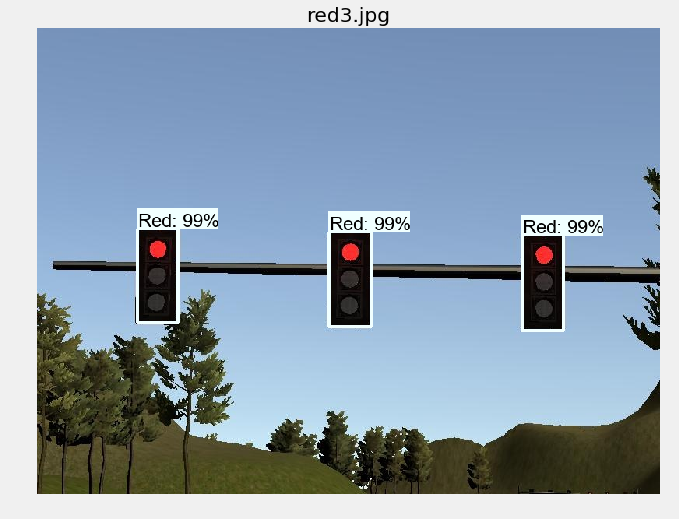

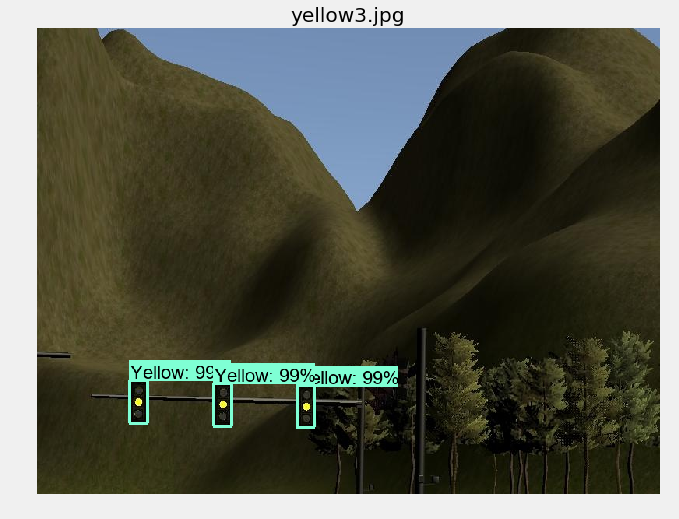

In [40]:
with tf.Session(graph=detection_graph) as sess:
    for image_file in test_images:
        image_path = PATH_TO_TEST_IMAGES_DIR + '/' + image_file
        image = Image.open(image_path)
        
        (im_width, im_height) = image.size
        image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

        # Actual detection.
        (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                            feed_dict={image_tensor: np.expand_dims(image_np, 0)})

        # Remove unnecessary dimensions
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes)

#         confidence_cutoff = 0.7
#         # Filter boxes with a confidence score less than `confidence_cutoff`
#         boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)
        
        vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          boxes,
          classes.astype(np.int32),
          scores,
          category_index,
          use_normalized_coordinates=True,
          line_thickness=4)
        
        
        plt.figure(figsize=(12, 8))
        plt.title(image_file)
        plt.axis('off')
        plt.imshow(image_np)

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [41]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    image_path = PATH_TO_TEST_IMAGES_DIR + '/' + test_images[0]
    image = Image.open(image_path)
    (im_width, im_height) = image.size
    image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: np.expand_dims(image_np, 0)})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [42]:
with tf.Session(graph=detection_graph) as sess:
    times = time_detection(sess, 600, 1000, runs=10)

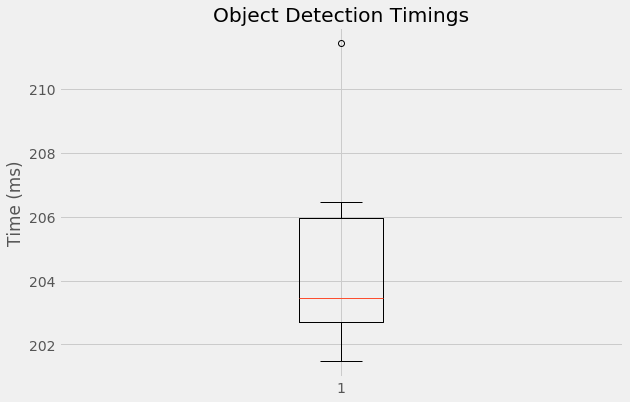

In [43]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)

## Detection on a Video

Testing pipeline on a video

In [44]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('simulator.mp4'))

### Exercise 5 - Object Detection on a Video

Run an object detection pipeline on the above clip.

In [45]:
clip = VideoFileClip('simulator.mp4')

In [46]:
# TODO: Complete this function.
# The input is an NumPy array.
# The output should also be a NumPy array.
def pipeline(img):
#     image_np = np.expand_dims(np.asarray(img, dtype=np.uint8), 0)
#     image_np = np.expand_dims(img, 0)
    draw_img = Image.fromarray(img)
    image_np = np.expand_dims(img, 0)
             
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

#     confidence_cutoff = 0.7
#     # Filter boxes with a confidence score less than `confidence_cutoff`
#     boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

#     # The current box coordinates are normalized to a range between 0 and 1.
#     # This converts the coordinates actual location on the image.
#     width, height = draw_img.size
#     box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
#     draw_boxes(draw_img, box_coords, classes)
    
    (im_width, im_height) = draw_img.size
    image_np = np.array(draw_img.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

    vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              boxes,
              classes.astype(np.int32),
              scores,
              category_index,
              use_normalized_coordinates=True,
              line_thickness=4)
    return image_np

#         plt.figure(figsize=(12, 8))
#         plt.imshow(image) 
#     return np.array(draw_img)

In [47]:
with tf.Session(graph=detection_graph) as sess:
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    new_clip = clip.fl_image(pipeline)
    
    # write to file
    new_clip.write_videofile('result.mp4')

Moviepy - Building video faster_rcnn_resnet101_coco_sim.mp4.


Moviepy - Writing video faster_rcnn_resnet101_coco_sim.mp4



t:   4%|██                                            | 161/3671 [01:32<33:12,  1.76it/s, now=None]


t:   9%|████                                          | 323/3671 [03:05<33:30,  1.66it/s, now=None]


t:  13%|██████                                        | 485/3671 [04:40<31:08,  1.70it/s, now=None]


t:  18%|████████                                      | 647/3671 [06:12<28:25,  1.77it/s, now=None]


t:  22%|██████████▏                                   | 809/3671 [07:44<28:54,  1.65it/s, now=None]


t:  26%|████████████▏                                 | 971/3671 [09:16<25:07,  1.79it/s, now=None]


t:  31%|█████████████▉                               | 1133/3671 [10:48<25:05,  1.69it/s, now=None]


t:  35%|███████████████▊                             | 1295/3671 [12:23<22:17,  1.78it/s, now=None]


t:  40%|█████████████████▊                           | 1457/3671 [13:56<21:32,  1.71it/s, now=None]


t:  44%|███████████████████▊                         | 1619/3671 [15:30<19:06,  1.79it/s, now=None]


t:  49%|█████████████████████▊                       | 1781/3671 [17:00<17:39,  1.78it/s, now=None]


t:  53%|███████████████████████▊                     | 1943/3671 [18:31<16:17,  1.77it/s, now=None]


t:  57%|█████████████████████████▊                   | 2105/3671 [20:02<14:27,  1.81it/s, now=None]


t:  62%|███████████████████████████▊                 | 2267/3671 [21:33<13:00,  1.80it/s, now=None]


t:  66%|█████████████████████████████▊               | 2429/3671 [23:03<12:25,  1.67it/s, now=None]


t:  71%|███████████████████████████████▊             | 2591/3671 [24:34<10:00,  1.80it/s, now=None]


t:  75%|█████████████████████████████████▋           | 2753/3671 [26:05<08:41,  1.76it/s, now=None]


t:  79%|███████████████████████████████████▋         | 2915/3671 [27:36<07:00,  1.80it/s, now=None]


t:  84%|█████████████████████████████████████▋       | 3077/3671 [29:06<05:32,  1.79it/s, now=None]


t:  88%|███████████████████████████████████████▋     | 3239/3671 [30:37<04:03,  1.77it/s, now=None]


t:  93%|█████████████████████████████████████████▋   | 3401/3671 [32:11<02:30,  1.79it/s, now=None]


t:  97%|███████████████████████████████████████████▋ | 3563/3671 [33:41<00:59,  1.81it/s, now=None]


t: 100%|█████████████████████████████████████████████| 3671/3671 [34:42<00:00,  1.80it/s, now=None]


Moviepy - Done !


Moviepy - video ready faster_rcnn_resnet101_coco_sim.mp4


t:   2%|▋                                            | 61/3671 [2:43:44<29:52,  2.01it/s, now=None]

In [ ]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('result.mp4'))